References : 

https://stackoverflow.com/questions/50954479/using-cuda-with-pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
#Loading in data from MNIST dataset
df_train = pd.read_csv('./sample_data/mnist_train_small.csv')
df_test = pd.read_csv('./sample_data/mnist_test.csv')

In [3]:
idx = 6 
row = df_test.iloc[idx]
img = row[1:].values.reshape(28,28)

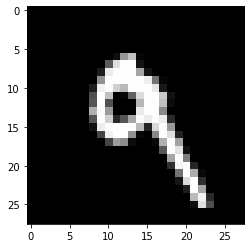

In [4]:
plt.imshow(img, cmap='gray') #A label for the 6th row of the dataframe 

In [5]:
#Must implement this class and 3 methods in order to initialize, get length and get item from the digits dataset
class DigitsDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df 
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        
        x = np.float32(row[1:].values) / 255.0
        y = row[0]
        
        return x,y

In [6]:
#Using the DigitsDataset class for the training and testing dataset
dataset_train = DigitsDataset(df_train)
dataset_test = DigitsDataset(df_test)

In [7]:
#Using the dataloader, it grabs a batch of data, in this case the batch size is 64
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle = True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 64, shuffle = True)

In [8]:
#Gets one batch of data
X_batch, Y_batch = next(iter(dataloader_train))

tensor(1)


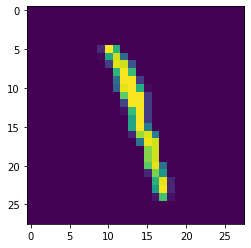

In [9]:
#Reshaping the data into 28,28 
plt.imshow(np.reshape(X_batch[0],(28,28)))

#Image of the first row in the test labels 
print(Y_batch[0])

In [10]:
#A class to specify the Neural Network architecture 
class LogReg_NeuralNetwork(torch.nn.Module):
    #Initializing the neural network 
    def __init__(self,input_size,num_classes):
        
        super(LogReg_NeuralNetwork,self).__init__()
        self.linear = torch.nn.Linear(input_size,num_classes)

        
    #Function that applies the neural network to a vector x   
    def forward(self,x):
        
        result = self.linear(x)
        return result

In [11]:
# Hyper Parameters 
input_size = X_batch.shape[1] #784
num_classes = 10

In [12]:
model = LogReg_NeuralNetwork(input_size, num_classes) #The Neural Network 

In [13]:
#Using the cuda GPU if it is available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) #Directing our model to our device

In [65]:
loss_fun = torch.nn.CrossEntropyLoss() #Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #Similar to Stochastic Gradient Descent 

In [76]:
#Training the Neural Network
num_epochs = 10
N_train = len(dataset_train)
N_test = len(dataset_test)

train_losses = [] #Collect training losses
test_losses = [] #Collect testing losses 

#For the number of epochs 
for ep in range(num_epochs):
    
    model.train() #Puts model in training mode
    train_loss = 0.0
    batch_idx = 0
    
    for X_batch, y_batch in dataloader_train: #Go through training data one batch at a time 
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_onebatch = loss_fun(outputs,y_batch)
        
        model.zero_grad()
        loss_onebatch.backward() #PyTorch computes gradient 
        optimizer.step() #One iteration of stochastic gradient descent / Adam 
        
        train_loss += loss_onebatch * N_batch
        
    model.eval() #Puts model in testing mode 
    test_loss = 0.0
    
    for X_batch, y_batch in dataloader_test:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        with torch.no_grad(): #Tells pyTorch that it does not need to keep track of gradient info
            N_batch = X_batch.shape[0]
            outputs = model(X_batch)
            loss_onebatch = loss_fun(outputs,y_batch)
            test_loss += loss_onebatch * N_batch
            
    train_losses.append(train_loss/N_train)
    test_losses.append(test_loss/N_train)
    
    print('Epoch : ', ep , '| Train Loss : ', train_loss/N_train, '| Test Loss : ', test_loss/N_train)
        

Epoch :  0 | Train Loss :  tensor(1.4103, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.7332)
Epoch :  1 | Train Loss :  tensor(1.3916, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.7439)
Epoch :  2 | Train Loss :  tensor(1.3587, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.7258)
Epoch :  3 | Train Loss :  tensor(1.3308, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.6656)
Epoch :  4 | Train Loss :  tensor(1.3503, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.6749)
Epoch :  5 | Train Loss :  tensor(1.2937, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.6851)
Epoch :  6 | Train Loss :  tensor(1.3077, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.6633)
Epoch :  7 | Train Loss :  tensor(1.2815, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.7208)
Epoch :  8 | Train Loss :  tensor(1.2762, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.7286)
Epoch :  9 | Train Loss :  tensor(1.2592, grad_fn=<DivBackward0>) | Test Loss :  tensor(5.6505)


Text(0.5, 1.0, 'Objective Function vs Epoch')

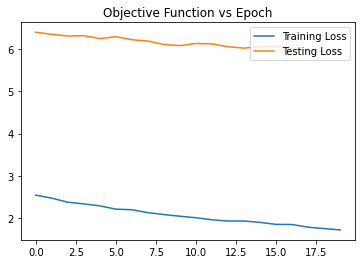

In [72]:
#A plot of the Objective Function against the Epochs 
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Testing Loss')
plt.legend(loc='upper right')
plt.title('Objective Function vs Epoch')

In [75]:
#Calculates the number of correct predictions and gives us the accuracy 
num_correct = 0 
model.eval()

for X_batch, y_batch in dataloader_test: 
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    
    with torch.no_grad():
        outputs = model(X_batch)
        num_correct += sum(np.argmax(outputs,axis=1) == y_batch)
        
print('Accuracy : ', num_correct/N_test)

Accuracy :  tensor(0.8900)


Increasing the learning rate here decreased the accuracy, from 90% (lr = 0.01) to 88% (lr = 0.1) 

Learning Rate of 0.001 and Epoch 10 : 90% 

Learning Rate of 0.001 and Epoch 15 : 89% 

Learning Rate of 0.001 and Epoch 20 : 88% 